<a href="https://colab.research.google.com/github/am-tropin/georgian-letters-trainer/blob/main/Georgian_letters_recognition_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1. Choose a dataset**

In [1]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/alexandertropin/georgian-letters-photo-database")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alexandertropin
Your Kaggle Key: ··········


100%|██████████| 337M/337M [00:05<00:00, 68.1MB/s]


In [57]:
# remove all .txt files

# import os
# import glob

# fileList = glob.glob('/content/georgian-letters-photo-database/georgian_letters_image_database/dataset/yolo/*') # .txt
# fileList = glob.glob('/content/georgian-letters-photo-database/georgian_letters_image_database/dataset/*') # .txt
# fileList = glob.glob('/content/georgian-letters-photo-database/georgian_letters_image_database/for_prediction/*') # .txt
# fileList = glob.glob('/content/georgian-letters-photo-database/georgian_letters_image_database/dataset/*') # .txt
# fileList = glob.glob('/content/georgian-letters-photo-database/georgian_letters_image_database/dataset/*') # .txt

# for filePath in fileList:
#     os.remove(filePath)

# **Step 2. To chop up the letters**

In [15]:
import cv2
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET

import glob
import os

# import sys, random
# from shutil import copyfile

In [7]:
# https://github.com/Shenggan/BCCD_Dataset/blob/master/export.py


def to_extract_coordinates(source_folder, target_name):
    annotations = glob.glob(source_folder + '*.xml')

    df = []
    cnt = 0

    for file in annotations:
        filename = file.split('/')[-1].split('.')[0] + '.jpg'
        row = []
        parsedXML = ET.parse(file)
        for node in parsedXML.getroot().iter('object'):
            letters = node.find('name').text
            xmin = int(node.find('bndbox/xmin').text)
            xmax = int(node.find('bndbox/xmax').text)
            ymin = int(node.find('bndbox/ymin').text)
            ymax = int(node.find('bndbox/ymax').text)

            row = [filename, letters, xmin, xmax, ymin, ymax]
            df.append(row)
            cnt += 1

    data = pd.DataFrame(df, columns=['filename', 'letter_name', 'xmin', 'xmax', 'ymin', 'ymax'])

    data[['filename', 'letter_name', 'xmin', 'xmax', 'ymin', 'ymax']].to_csv(target_name + '.csv', index=False)
    return 1

In [8]:
source_folder = 'georgian-letters-photo-database/georgian_letters_image_database/dataset/'
target_name = 'label_coordinates'

to_extract_coordinates(source_folder, target_name)

1

In [9]:
df = pd.read_csv('label_coordinates.csv')
df.head()

,filename,letter_name,xmin,xmax,ymin,ymax
0,IMG_20230213_213058.jpg,30ხ,912,1048,92,420
1,IMG_20230213_213058.jpg,25ჩ,1502,1703,92,442
2,IMG_20230213_213058.jpg,7თ,1673,1808,752,918
3,IMG_20230213_213058.jpg,7თ,545,733,1071,1229
4,IMG_20230213_213058.jpg,1ბ,659,794,1561,1911


In [10]:
def invert_image(img_test):
    height, width = img_test.shape[:2]
    border_delta = 0.02

    # mean grayscale value
    mean_image = np.mean(img_test)

    # grayscale values near the borders
    mean_left_border = np.mean(img_test[:, int(width*(1-border_delta)):width])
    mean_right_border = np.mean(img_test[:, 0:int(width*border_delta)])
    mean_upper_border = np.mean(img_test[0:int(height*border_delta), :])
    mean_lower_border = np.mean(img_test[int(height*(1-border_delta)):height, :])

    if mean_image > np.mean(np.array([mean_left_border, mean_right_border, mean_upper_border, mean_lower_border])):
        return cv2.bitwise_not(img_test)
    else:
        return img_test


In [11]:
!mkdir cropped_images


In [12]:
# df_short = df[df['filename'] == 'IMG_20230212_163927.jpg']
# df_short = df[df['filename'] == 'IMG_20230215_140350 (1).jpg']


In [12]:
def to_crop_letters(df, source_folder, target_folder):
    letter_names = set(list(df['letter_name']))

    # a counter of letters within each image
    letter_counter = {}

    for index, row in df.iterrows():
        if row['filename'] in letter_counter.keys():
            if row['letter_name'] in letter_counter[row['filename']].keys():
                letter_counter[row['filename']][row['letter_name']] += 1
            else:
                letter_counter[row['filename']][row['letter_name']] = 1
        else:
            letter_counter[row['filename']] = {}
            letter_counter[row['filename']][row['letter_name']] = 1

        img = cv2.imread(source_folder + row['filename'])
        crop_img = img[row['ymin']:row['ymax'], row['xmin']:row['xmax']]
        crop_resize_img = cv2.resize(crop_img, (100, 150))
        gray_crop_resize_img = cv2.cvtColor(crop_resize_img, cv2.COLOR_BGR2GRAY)
        invert_img = invert_image(gray_crop_resize_img)
        # thresh_img = invert_img
        thresh_img = cv2.threshold(invert_img, np.mean(invert_img), 255, cv2.THRESH_BINARY)[1]
        # thresh_img = cv2.threshold(invert_img, (np.amin(invert_img) + np.amax(invert_img))//2, 255, cv2.THRESH_BINARY)[1]
        # 127, 255
        # cv2.THRESH_BINARY: If pixel intensity is greater than the set threshold, value set to 255, else set to 0 (black).
        cv2.imwrite(target_folder + row['filename'][:-4] + '_' + row['letter_name'][-1] + '_' + str(letter_counter[row['filename']][row['letter_name']]) + '.jpg', thresh_img)
    return 1

In [13]:
'''
Creating a new dataset of images with singular letters.
Grayscale. 
Resized to 100x150.
Inverted (black <-> white) if the borders are darker than the image on the average
'''


'''
4.5 minutes for processing of a full dataset (86 images / 1302 letters)
'''

df_short = df #.head(100)

# the folder where images locate
source_folder = 'georgian-letters-photo-database/georgian_letters_image_database/dataset/'

# the folder where cropped images will be saved
target_folder = 'cropped_images/'

to_crop_letters(df_short, source_folder, target_folder)

1

In [18]:
# files = glob.glob('cropped_images/*')
# for f in files:
#     os.remove(f)

In [47]:
# !rmdir croped_images

Downloading the cropped images:

In [26]:
# !zip -r /content/cropped_images.zip /content/cropped_images

# from google.colab import files
# files.download("/content/cropped_images.zip")

In [16]:
import re

# path = "cropped_images/"
dir_list = os.listdir("cropped_images/")
# ა_list = [d for d in dir_list if "ა" in d]
letter_list = [re.findall("\_(.)\_", d)[0] for d in dir_list if re.findall("\_(.)\_", d)]


In [17]:
# to detect the most frequent letters

from collections import Counter

letter_counter = Counter(letter_list)
letter_counter.most_common()

[('ი', 105),
 ('ა', 99),
 ('რ', 87),
 ('ე', 79),
 ('ს', 74),
 ('ლ', 67),
 ('ნ', 63),
 ('ო', 62),
 ('ბ', 58),
 ('უ', 56),
 ('დ', 53),
 ('ვ', 50),
 ('მ', 50),
 ('ტ', 46),
 ('თ', 41),
 ('კ', 37),
 ('ფ', 35),
 ('გ', 34),
 ('ქ', 32),
 ('ხ', 26),
 ('შ', 22),
 ('ზ', 20),
 ('პ', 18),
 ('წ', 17),
 ('ც', 17),
 ('ჩ', 12),
 ('ყ', 11),
 ('ძ', 10),
 ('ღ', 9),
 ('ჟ', 5),
 ('ჯ', 4),
 ('ჭ', 2),
 ('ჰ', 1)]

# **Step 3. To distribute the top of letters by separate folders**

I will create folders for 8 most frequent letters and another one for the others.

In [18]:
import shutil

# src_path = r"E:\pynative\reports\sales.txt" # source
# dst_path = r"E:\pynative\account\sales.txt" # destination
# shutil.move(src_path, dst_path) # move
# shutil.copyfile(src_path, dst_path) # copy

In [19]:
treshold = 60

In [20]:
head_letter_dict = {x: count for x, count in Counter(letter_list).items() if count >= treshold}
head_letter_dict = {k: v for k, v in sorted(head_letter_dict.items(), key=lambda item: item[1], reverse=True)}
head_letter_dict

{'ი': 105, 'ა': 99, 'რ': 87, 'ე': 79, 'ს': 74, 'ლ': 67, 'ნ': 63, 'ო': 62}

In [21]:
tail_letter_dict = {x: count for x, count in Counter(letter_list).items() if count < treshold}
tail_letter_dict = {k: v for k, v in sorted(tail_letter_dict.items(), key=lambda item: item[1], reverse=True)}
# tail_letter_dict

In [22]:
head_letter_dict['other'] = np.sum([v for v in tail_letter_dict.values()])
head_letter_dict

{'ი': 105,
 'ა': 99,
 'რ': 87,
 'ე': 79,
 'ს': 74,
 'ლ': 67,
 'ნ': 63,
 'ო': 62,
 'other': 666}

In [134]:
# for filePath in glob.glob("cropped_images_i/*.jpg"):
#     filePath_splitted = filePath.split('/')
#     shutil.move(filePath, 'cropped_images/' + filePath_splitted[1])

In [23]:
del head_letter_dict['other']

In [24]:
base_dir = 'grouped_images'
os.mkdir(base_dir)

for letter in head_letter_dict.keys():
    os.mkdir(base_dir + '/letter_' + letter)

In [25]:
# distributing images with top of letters by folders
for letter in head_letter_dict.keys():
    fileList = [f for f in glob.glob("cropped_images/*.jpg") if letter in f]
    for filePath in fileList:
        filePath_splitted = filePath.split('/')
        shutil.copyfile(filePath, 'grouped_images/letter_'+letter+'/' + filePath_splitted[1])


In [20]:
# and the rest:
# fileList = [f for f in glob.glob("cropped_images/*.jpg") if not any(letter in f for letter in head_letter_dict.keys())]
# for filePath in fileList:
#     filePath_splitted = filePath.split('/')
#     shutil.copyfile(filePath, 'grouped_images/letter_other/' + filePath_splitted[1])


# **Step 4. To distribute images by test, validation and train folders for each letter**

based on https://www.analyticsvidhya.com/blog/2022/07/training-cnn-from-scratch-using-the-custom-dataset/

In [26]:
base_dir = 'grouped_images'
dataset_types = ["train", "validation", "test"]

In [27]:
for t in dataset_types:
    t_dir = os.path.join(base_dir, t)
    os.mkdir(t_dir)
    for letter in head_letter_dict.keys():
        t_letter_dir = os.path.join(t_dir, letter)
        os.mkdir(t_letter_dir)


In [28]:
letter_sizes = {}

for letter, amount in head_letter_dict.items():
    letter_sizes[letter] = {}
    letter_sizes[letter]['test'] = int(np.floor(amount * 0.2))
    letter_sizes[letter]['validation'] = int(np.floor((amount - letter_sizes[letter]['test']) * 0.2))
    letter_sizes[letter]['train'] = amount - (letter_sizes[letter]['test'] + letter_sizes[letter]['validation'])
    # print(head_letter_dict[letter])

letter_sizes

{'ი': {'test': 21, 'validation': 16, 'train': 68},
 'ა': {'test': 19, 'validation': 16, 'train': 64},
 'რ': {'test': 17, 'validation': 14, 'train': 56},
 'ე': {'test': 15, 'validation': 12, 'train': 52},
 'ს': {'test': 14, 'validation': 12, 'train': 48},
 'ლ': {'test': 13, 'validation': 10, 'train': 44},
 'ნ': {'test': 12, 'validation': 10, 'train': 41},
 'ო': {'test': 12, 'validation': 10, 'train': 40}}

In [24]:
# '''
# TO DELETE OTHER LETTERS
# '''

# files = glob.glob('grouped_images/letter_other/*')
# for f in files:
#     os.remove(f)

# !rmdir grouped_images/letter_other

In [29]:
# del head_letter_dict['other']

In [29]:
for letter in head_letter_dict.keys():
    file_names = [f.split('/')[-1] for f in os.listdir('grouped_images/letter_' + letter)]

    test_names = file_names[:letter_sizes[letter]['test']]
    validation_names = file_names[letter_sizes[letter]['test']:letter_sizes[letter]['test']+letter_sizes[letter]['validation']]
    train_names = file_names[-letter_sizes[letter]['train']:]

    original_dir = 'grouped_images/letter_' + letter

    for f in test_names:
        target_dir = 'grouped_images/test/' + letter
        src = os.path.join(original_dir, f)
        dst = os.path.join(target_dir, f)
        shutil.copyfile(src, dst)

    for f in validation_names:
        target_dir = 'grouped_images/validation/' + letter
        src = os.path.join(original_dir, f)
        dst = os.path.join(target_dir, f)
        shutil.copyfile(src, dst)

    for f in train_names:
        target_dir = 'grouped_images/train/' + letter
        src = os.path.join(original_dir, f)
        dst = os.path.join(target_dir, f)
        shutil.copyfile(src, dst)


# **Step 5. Training CNN**

based on https://www.analyticsvidhya.com/blog/2022/07/training-cnn-from-scratch-using-the-custom-dataset/

about handwritten letters: https://data-flair.training/blogs/handwritten-character-recognition-neural-network/

In [ ]:
# ??????

# import tensorflow as tf
# import tensorflow_datasets as tfds

# # tf.enable_eager_execution()

# from keras.layers.core import Dense, Activation, Dropout, Flatten
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
# from keras.optimizers import SGD, RMSprop, Adam
# from keras.utils import np_utils
# from keras.models import Sequential

# from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
# from sklearn import metrics
# from sklearn.utils import shuffle
# from sklearn.model_selection import train_test_split

# import matplotlib.image as mpimg
# import matplotlib.pyplot as plt
# import random
# # from numpy import *
# from PIL import Image
# import theano

In [30]:
# based on: https://medium.com/artificialis/get-started-with-computer-vision-by-building-a-digit-recognition-model-with-tensorflow-b2216823b90a

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.optimizers import SGD, Adam

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 100, 1)))
model.add(Conv2D(16, (3, 3), activation='relu')) # , padding='same'
# model.add(MaxPool2D((2, 2), strides=2))
model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(Conv2D(16, (3, 3), activation='relu'))
# model.add(MaxPool2D((2, 2), strides=2))
model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(16, (3, 3), activation='relu', padding='valid'))
# model.add(MaxPool2D((2, 2), strides=2))
# model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))

model.add(Dense(8, activation='softmax')) # sigmoid # 1
# == num_classes 9 8 ?
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 98, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 96, 16)       2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 48, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 46, 16)        2320      
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 44, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 22, 16)       0         
 2D)                                                    

In [65]:
# '''
# OLD VERSION
# '''

# ###-----Build Your Model------###
# # from keras import layers
# # from keras import models

# # from keras.models import Sequential
# # from keras.layers.core import Dense, Activation, Dropout, Flatten
# # from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D

# from keras.models import Sequential
# from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
# from keras.optimizers import SGD, Adam

# model = Sequential()

# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 100, 1)))
# # model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
# model.add(MaxPool2D((2, 2), strides=2))
# model.add(Dropout(0.25))

# # model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# # model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# # model.add(MaxPool2D((2, 2), strides=2))
# # model.add(Dropout(0.25))

# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# # model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(MaxPool2D((2, 2), strides=2))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (3, 3), activation='relu', padding='valid'))
# # model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(MaxPool2D((2, 2), strides=2))
# model.add(Dropout(0.25))

# # model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# # model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# # model.add(MaxPool2D((2, 2), strides=(2,2)))
# # model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))

# model.add(Dense(1, activation='softmax')) # sigmoid # 1
# # == num_classes
# # 9 ?
# model.summary()


In [31]:
####----Configuring the model for training-----####
from tensorflow import keras
from keras import optimizers

model.compile(loss='categorical_crossentropy', # binary_crossentropy 
              # sparse_categorical_crossentropy - 9 classes
              # categorical_crossentropy - 8 classes
              optimizer=keras.optimizers.Adam(), 
              # optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), 
              metrics=['accuracy'])


In [32]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [33]:
#####-----Data Preprocessing-----######

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# about .flow_from_directory: https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 100), batch_size=5, class_mode='categorical', color_mode = 'grayscale') # was: 'binary'
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 100), batch_size=5, class_mode='categorical', color_mode = 'grayscale') # was: batch_size=20

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

Found 413 images belonging to 8 classes.
Found 100 images belonging to 8 classes.
data batch shape: (5, 150, 100, 1)
labels batch shape: (5, 8)


In [34]:
####----Fit the Model----####
history = model.fit(train_generator, epochs=4, validation_data=validation_generator)
# 10 4 
# steps_per_epoch=5, 
# , validation_steps=50
# about parameters: https://datascience.stackexchange.com/questions/29719/how-to-set-batch-size-steps-per-epoch-and-validation-steps

######-----Save the Model-------######
model.save('geo_letters_top8.h5')

Epoch 1/4
83/83 [==============================] - 15s 156ms/step - loss: 1.3417 - accuracy: 0.5375 - val_loss: 0.5390 - val_accuracy: 0.8800
Epoch 2/4
83/83 [==============================] - 12s 142ms/step - loss: 0.3607 - accuracy: 0.9007 - val_loss: 0.4420 - val_accuracy: 0.8600
Epoch 3/4
83/83 [==============================] - 12s 143ms/step - loss: 0.1280 - accuracy: 0.9637 - val_loss: 0.4941 - val_accuracy: 0.8800
Epoch 4/4
83/83 [==============================] - 12s 138ms/step - loss: 0.0347 - accuracy: 0.9903 - val_loss: 0.4475 - val_accuracy: 0.9000


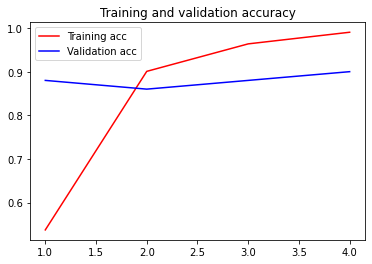

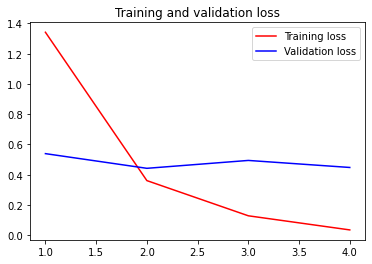

In [35]:
######-----Displaying curves of loss and accuracy during training-------######
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [36]:
history.history

{'loss': [1.3416625261306763,
  0.3607424199581146,
  0.12802785634994507,
  0.03465598076581955],
 'accuracy': [0.537530243396759,
  0.9007263779640198,
  0.9636803865432739,
  0.990314781665802],
 'val_loss': [0.5390323400497437,
  0.4419527053833008,
  0.49407655000686646,
  0.4475483000278473],
 'val_accuracy': [0.8799999952316284,
  0.8600000143051147,
  0.8799999952316284,
  0.8999999761581421]}

comment
<!-- BECAUSE val_loss and val_accuracy were only after first Epoch
**BUT WHY?**

Epoch 1/4
10/10 [==============================] - ETA: 0s - loss: 2.0863 - accuracy: 0.2642WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50 batches). You may need to use the repeat() function when building your dataset.
10/10 [==============================] - 5s 385ms/step - loss: 2.0863 - accuracy: 0.2642 - val_loss: 1.9104 - val_accuracy: 0.3700

Epoch 2/4

10/10 [==============================] - 3s 342ms/step - loss: 1.5920 - accuracy: 0.5050

Epoch 3/4

10/10 [==============================] - 3s 290ms/step - loss: 0.6316 - accuracy: 0.7824

Epoch 4/4

10/10 [==============================] - 3s 305ms/step - loss: 0.5871 - accuracy: 0.8200 -->


# **Conclusion**

The next conditions make better results (**accuracy = 87%**) than previous:

- Only Top-8 letters, without other
- 9 in the last layer (Dense)
- Small numbers of filters (16)
- 'sparse_categorical_crossentropy' and Adam
- validation_steps = 40 (**WHY?**)

# **Step 6. Prediction for an external image**

In [38]:
predict_img = cv2.imread("/content/georgian-letters-photo-database/georgian_letters_image_database/for_prediction/IMG_20230219_144541.jpg")

# predict_labels_df = pd.read_csv("/content/georgian-letters-photo-database/georgian_letters_image_database/for_prediction/IMG_20230219_144541.csv")
# predict_labels_df

In [39]:
!mkdir cropped_images_for_prediction

In [40]:
source_folder = 'georgian-letters-photo-database/georgian_letters_image_database/for_prediction/'
target_name = 'label_coordinates_pred'

to_extract_coordinates(source_folder, target_name)
df_pred = pd.read_csv(target_name + '.csv')


In [41]:
# the folder where images locate
source_folder_pred = 'georgian-letters-photo-database/georgian_letters_image_database/for_prediction/'

# the folder where cropped images will be saved
target_folder_pred = 'cropped_images_for_prediction/'

to_crop_letters(df_pred, source_folder_pred, target_folder_pred)

1

In [42]:
# dictionary of Georgian alphabet

df = pd.read_csv('label_coordinates.csv')
letter_names = list(set(list(df['letter_name'])))

geo_dict = {}
for letter_name in letter_names:
    geo_dict[int(letter_name[:-1])] = letter_name[-1]

# print(geo_dict)

based on: https://data-flair.training/blogs/handwritten-character-recognition-neural-network/

In [90]:
# example for 'ა'

# img_url = '/content/cropped_images_for_prediction/IMG_20230219_144541_ა_1.jpg'
# ok
# img_url = '/content/cropped_images_for_prediction/IMG_20230219_144541_ი_1.jpg'
# not ok
# img_url = '/content/cropped_images_for_prediction/IMG_20230219_144541_ი_2.jpg'
# not ok
# img_url = '/content/cropped_images_for_prediction/IMG_20230219_144541_კ_1.jpg'
# not ok
# img_url = '/content/cropped_images_for_prediction/IMG_20230219_144541_ლ_1.jpg'
# not ok
# img_url = '/content/cropped_images_for_prediction/IMG_20230219_144541_ნ_1.jpg'
# not ok
# img_url = '/content/cropped_images_for_prediction/IMG_20230219_144541_ხ_1.jpg'
# not ok

# pred_img = cv2.imread(img_url)
# img_final = np.reshape(pred_img, (3,150,100,1))

# print("The letter on the image is {0}".format(geo_dict[np.argmax(model.predict(img_final))]))


1/1 [==============================] - 0s 97ms/step
The letter on the image is ა


In [43]:
head_letter_dict.keys()

dict_keys(['ი', 'ა', 'რ', 'ე', 'ს', 'ლ', 'ნ', 'ო'])

In [44]:
import re

pred_folder = "cropped_images_for_prediction/"

pred_dir_list = os.listdir(pred_folder)
# ა_list = [d for d in dir_list if "ა" in d]
pred_letter_list = [re.findall("\_(.)\_", d)[0] for d in pred_dir_list if re.findall("\_(.)\_", d)]

# if letter in head_letter_dict.keys()

for img_url in pred_dir_list:
    letter = re.findall("\_(.)\_", img_url)[0]
    if letter in head_letter_dict.keys():
        print()
        print()
        pred_img = cv2.imread(pred_folder+img_url)
        img_final = np.reshape(pred_img, (3,150,100,1))
        # recognized_letter = geo_dict[np.argmax(model.predict(img_final))] # NO RELATED TO geo_dict !!!
        print(img_url, letter, np.argmax(model.predict(img_final)))
        print(model.predict(img_final))
        # if recognized_letter == letter:
        #     print("RECOGNIZED CORRECTLY:", letter)
        # else:
        #     print("RECOGNIZED INCORRECTLY: real - {}, recognized - {}".format(letter, recognized_letter))




1/1 [==============================] - 0s 147ms/step
IMG_20230219_144541_ლ_1.jpg ლ 0
1/1 [==============================] - 0s 38ms/step
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


1/1 [==============================] - 0s 38ms/step
IMG_20230219_144541_ა_1.jpg ა 7
1/1 [==============================] - 0s 38ms/step
[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]]


1/1 [==============================] - 0s 42ms/step
IMG_20230219_144541_ნ_1.jpg ნ 5
1/1 [==============================] - 0s 45ms/step
[[0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


1/1 [==============================] - 0s 48ms/step
IMG_20230219_144541_ი_2.jpg ი 0
1/1 [==============================] - 0s 44ms/step
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]


1/1 [==============================] - 0s 39ms/step
IMG_20230219_144541_ი_1.jpg ი 8
1/1 [============================

1/1 [==============================] - 0s 38ms/step


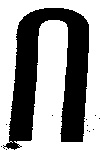

In [45]:
from google.colab.patches import cv2_imshow

img_final = np.reshape(pred_img, (3,150,100,1))

img_pred = geo_dict[np.argmax(model.predict(img_final))]

# # cv2.putText(img, "Dataflair _ _ _ ", (20,25), cv2.FONT_HERSHEY_TRIPLEX, 0.7, color = (0,0,230))
cv2.putText(pred_img, "Prediction: " + img_pred, (20,410), cv2.FONT_HERSHEY_DUPLEX, 1.3, color = (255,0,30))
cv2_imshow(pred_img)


# **What to do next:**


  - **TO CHECK ALL THE LABELS ON ALL THE PHOTOS -- THERE ARE MISTAKES**
  <!-- - to view the cropped dataset and remove noisy images (totally black and so on) or maybe to change threshold for black/white masking -->
  - to top up the dataset
  - TO TRY **scipy.ndimage as ndi** and **smoothing** or sharping (DataCamp, biomedical, chapter 2, lesson 3)
  - to fix validation curves on graphics
  - **TO VISUALIZE A PREDICTION**

Downloading the cropped images:

In [108]:
# Downloading the cropped images:

# !zip -r /content/cropped_images.zip /content/cropped_images

# from google.colab import files
# files.download("/content/cropped_images.zip")

In [ ]:
# !zip -r /content/grouped_images.zip /content/grouped_images

# from google.colab import files
# files.download("/content/grouped_images.zip")

# **===== DRAFTS =====**

In [79]:
from google.colab.patches import cv2_imshow


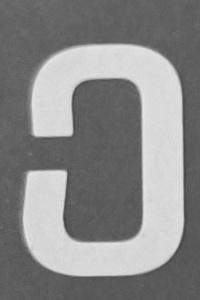

In [51]:
img_test = cv2.imread("/content/cropped_images/IMG_20230212_163114_ე_1.jpg")

cv2_imshow(img_test)


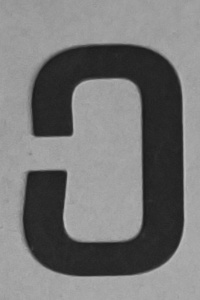

In [75]:
cv2_imshow(invert_image(img_test))


In [226]:
x = []
img = Image.open('grouped_images/train/ა/IMG_20220404_150259_ა_1.jpg')
img.load()
data = np.asarray(img, dtype="int32")
x.append(data)
x = np.array(x)
print(x.shape)

(1, 150, 100)


In [53]:
# threshold
thresh = cv2.threshold(img_test, 180, 255, cv2.THRESH_BINARY)[1]

# count number of white pixels
mean = np.mean(img_test)
print("mean =", mean)

mean_masked = np.mean(img_test[np.where(thresh == 255)])
print("masked mean =", mean_masked)


mean = 136.24663333333334
masked mean = 215.07470801449858


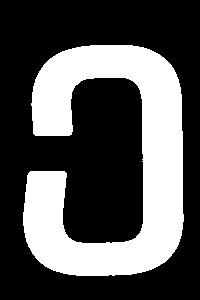

-1

In [56]:
# write thresh to disk
cv2.imwrite("gray_with_spots_thresh.png", thresh)

# display it
cv2_imshow(thresh)
cv2.waitKey(0)

In [ ]:
# #creating two dir for training and testing
# !mkdir test_labels train_labels

# # lists the files inside 'annotations' in a random order (not really random, by their hash value instead)
# # Moves the first 274/1370 labels (20% of the labels) to the testing dir: `test_labels`
# !ls annotations/* | sort -R | head -274 | xargs -I{} mv {} test_labels/

# # Moves the rest of the labels ( 1096 labels ) to the training dir: `train_labels`
# !ls annotations/* | xargs -I{} mv {} train_labels/

In [6]:
#creating two dir for training and testing
!mkdir test_labels train_labels

In [11]:
#creating two dir for training and testing
!mkdir test train

In [7]:
# 86 * 0.2

17.2

In [10]:
# Moves the first 51/86 labels (20% of the labels) to the testing dir: `test_labels`
!ls georgian-letters-photo-database/* | head -51 | xargs -I{} mv {} test/

# to cancel:
# !ls test/* | xargs -I{} mv {} georgian-letters-photo-database/

In [13]:
!ls georgian-letters-photo-database/* | xargs -I{} mv {} train/